In [1]:
import torch
import cv2
import numpy as np
import pandas as pd 
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
from ADD_GCN import DynamicGraphConvolution,ADD_GCN
matplotlib.style.use('ggplot')
#忽略警告
import warnings
warnings.filterwarnings("ignore")
# data = pd.read_csv('D:\ML_data_sql\info_label_clean.csv',encoding='utf-8')
# df = data.drop('Unnamed: 0',axis=1)
# df.head()

In [2]:
#dataset
#可以resize 400*400
#0.85 训练 0.15 验证
#make dataset
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]['id']
        self.all_labels = np.array(self.csv.drop(['Unnamed: 0','id'], axis=1))
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio

        # set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            #make data argumentaion
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                #p=0.5 to horizontal turn over 
                transforms.RandomHorizontalFlip(p=0.5),
                #（-45，45） angle to revolve
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
            ])

        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            #[:10] to predict and show the effect 
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:])

            # define the validation transforms  resize 400*400
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])

        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-10:])
            self.labels = list(self.all_labels[-10:])

             # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = cv2.imread(f"D:\\ML_data_sql\\poster_img\\{self.image_names[index]}.jpg")
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }


In [3]:
from torchvision import models as models
import torch.functional as F
def model(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 25 classes in total
    model.fc = nn.Linear(2048, 36)
    return model

#model 2 
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 400, 400]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 400, 400]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 200,200]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 200,200]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 100, 100]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 50, 50]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 25, 25]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 25, 25]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 1),       # [512, 13, 13]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*13*13, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 36)
        )
        
        

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()

In [4]:
from sklearn.metrics import average_precision_score,roc_auc_score
def compute_mAP(outputs,labels):
    y_true = labels.cpu().detach().numpy()
    y_pred = outputs.cpu().detach().numpy()
    AP = []
    for i in range(y_true.shape[0]):
        AP.append(average_precision_score(y_true[i],y_pred[i]))
    return np.mean(AP)

def comput_roc(outputs,labels):
    y_true = labels.cpu().detach().numpy()
    y_pred = outputs.cpu().detach().numpy()
    ROC = []
    for i in range(y_true.shape[0]):
        ROC.append(roc_auc_score(y_true[i],y_pred[i]))
    return np.mean(ROC)

In [5]:
from sklearn.metrics import precision_score,recall_score,f1_score
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            }

In [6]:
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    train_running_mAP = 0.0
    train_running_ROC = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        output1,output2 = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = (output1+output2)/2
        # outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        train_running_mAP += compute_mAP(outputs,target)
        train_running_ROC += comput_roc(outputs,target)
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_mAP = train_running_mAP/counter
    train_ROC = train_running_ROC/counter
    print(f"Train mAP: {train_mAP:.4f}")
    print(f'Train ROC: {train_ROC:.4f}')
    return train_loss,train_mAP,train_ROC

In [7]:
# validation function
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    val_running_mAP = 0.0
    val_running_ROC = 0.0
    with torch.no_grad():
        model_result = []
        targets = []
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            # outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1

            output1,output2 = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = (output1+output2)/2
            # outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            model_result.extend(outputs.cpu().numpy())
            targets.extend(target.cpu().numpy())
            val_running_mAP += compute_mAP(outputs,target)
            val_running_ROC += comput_roc(outputs,target)
            val_running_loss += loss.item()
            
        result = calculate_metrics(np.array(model_result), np.array(targets))
        val_loss = val_running_loss / counter
        val_mAP = val_running_mAP/counter
        val_ROC = val_running_ROC/counter
        print("epoch:{:2d}  test: "
                  "micro f1: {:.3f} "
                  "macro f1: {:.3f} "
                  "samples f1: {:.3f}".format(epoch,
                                              result['micro/f1'],
                                              result['macro/f1'],
                                              result['samples/f1']))
        print(f"Val mAP: {val_mAP:.4f}")
        print(f'Val ROC: {val_ROC:.4f}')
        return val_loss,val_mAP,val_ROC

In [8]:
#train
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model2 = model(pretrained=True, requires_grad=False).to(device)
# model2 = Classifier().to(device)
premodel = models.resnet50(pretrained=True)
# premodel.eval()
model2 = ADD_GCN(premodel,36).to(device)  #ADD-GCN

In [9]:
# learning parameters
lr = 0.0001
epochs = 20
batch_size = 4
optimizer = optim.Adam(model2.parameters(), lr=lr)
criterion = nn.MultiLabelSoftMarginLoss()
# read the training csv file
print('load data...')
train_csv = pd.read_csv('D:\ML_data_sql\info_label_clean.csv')
# train dataset
train_data = ImageDataset(
    train_csv, train=True, test=False
)
# validation dataset
valid_data = ImageDataset(
    train_csv, train=False, test=False
)
# train data loader
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)
print('loaded over')
train_loss = []
valid_loss = []
train_mAP = []
train_ROC = []
valid_mAP = []
valid_ROC = []
print('begin to train')
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model2, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model2, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

load data...
Number of training images: 16393
Number of validation images: 2893
loaded over
begin to train
Epoch 1 of 20
Training


100%|██████████| 4098/4098 [21:59<00:00,  3.11it/s]


Train mAP: 0.5675
Train ROC: 0.9006
Validating


100%|██████████| 720/720 [01:46<00:00,  6.78it/s]


epoch: 0  test: micro f1: 0.257 macro f1: 0.046 samples f1: 0.223
Val mAP: 0.4572
Val ROC: 0.7848
Train Loss: 0.1835
Val Loss: 0.2259
Epoch 2 of 20
Training


100%|██████████| 4098/4098 [22:23<00:00,  3.05it/s]


Train mAP: 0.5903
Train ROC: 0.9091
Validating


100%|██████████| 720/720 [01:27<00:00,  8.19it/s]


epoch: 1  test: micro f1: 0.212 macro f1: 0.048 samples f1: 0.176
Val mAP: 0.4608
Val ROC: 0.8437
Train Loss: 0.1697
Val Loss: 0.2168
Epoch 3 of 20
Training


100%|██████████| 4098/4098 [22:27<00:00,  3.04it/s]


Train mAP: 0.5990
Train ROC: 0.9120
Validating


100%|██████████| 720/720 [01:25<00:00,  8.45it/s]


epoch: 2  test: micro f1: 0.159 macro f1: 0.048 samples f1: 0.126
Val mAP: 0.4403
Val ROC: 0.7736
Train Loss: 0.1673
Val Loss: 0.2433
Epoch 4 of 20
Training


100%|██████████| 4098/4098 [22:18<00:00,  3.06it/s]


Train mAP: 0.6140
Train ROC: 0.9164
Validating


100%|██████████| 720/720 [01:25<00:00,  8.44it/s]


epoch: 3  test: micro f1: 0.214 macro f1: 0.055 samples f1: 0.176
Val mAP: 0.4527
Val ROC: 0.8188
Train Loss: 0.1641
Val Loss: 0.2238
Epoch 5 of 20
Training


100%|██████████| 4098/4098 [21:42<00:00,  3.15it/s]


Train mAP: 0.6247
Train ROC: 0.9200
Validating


100%|██████████| 720/720 [01:35<00:00,  7.54it/s]


epoch: 4  test: micro f1: 0.101 macro f1: 0.042 samples f1: 0.072
Val mAP: 0.4170
Val ROC: 0.7786
Train Loss: 0.1609
Val Loss: 0.2310
Epoch 6 of 20
Training


100%|██████████| 4098/4098 [21:48<00:00,  3.13it/s]


Train mAP: 0.6344
Train ROC: 0.9228
Validating


100%|██████████| 720/720 [01:25<00:00,  8.46it/s]


epoch: 5  test: micro f1: 0.147 macro f1: 0.044 samples f1: 0.112
Val mAP: 0.4670
Val ROC: 0.8407
Train Loss: 0.1585
Val Loss: 0.2109
Epoch 7 of 20
Training


100%|██████████| 4098/4098 [21:48<00:00,  3.13it/s]


Train mAP: 0.6434
Train ROC: 0.9254
Validating


100%|██████████| 720/720 [01:25<00:00,  8.38it/s]


epoch: 6  test: micro f1: 0.127 macro f1: 0.043 samples f1: 0.093
Val mAP: 0.4728
Val ROC: 0.8523
Train Loss: 0.1560
Val Loss: 0.2038
Epoch 8 of 20
Training


100%|██████████| 4098/4098 [22:29<00:00,  3.04it/s]


Train mAP: 0.6534
Train ROC: 0.9280
Validating


100%|██████████| 720/720 [01:28<00:00,  8.17it/s]


epoch: 7  test: micro f1: 0.184 macro f1: 0.060 samples f1: 0.143
Val mAP: 0.4754
Val ROC: 0.8503
Train Loss: 0.1537
Val Loss: 0.2066
Epoch 9 of 20
Training


100%|██████████| 4098/4098 [22:36<00:00,  3.02it/s]


Train mAP: 0.6612
Train ROC: 0.9295
Validating


100%|██████████| 720/720 [01:25<00:00,  8.45it/s]


epoch: 8  test: micro f1: 0.193 macro f1: 0.049 samples f1: 0.154
Val mAP: 0.4739
Val ROC: 0.8443
Train Loss: 0.1518
Val Loss: 0.2052
Epoch 10 of 20
Training


100%|██████████| 4098/4098 [22:37<00:00,  3.02it/s]


Train mAP: 0.6671
Train ROC: 0.9317
Validating


100%|██████████| 720/720 [01:25<00:00,  8.41it/s]


epoch: 9  test: micro f1: 0.233 macro f1: 0.056 samples f1: 0.197
Val mAP: 0.4893
Val ROC: 0.8608
Train Loss: 0.1501
Val Loss: 0.2022
Epoch 11 of 20
Training


100%|██████████| 4098/4098 [21:32<00:00,  3.17it/s]


Train mAP: 0.6742
Train ROC: 0.9337
Validating


100%|██████████| 720/720 [01:19<00:00,  9.02it/s]


epoch:10  test: micro f1: 0.247 macro f1: 0.060 samples f1: 0.207
Val mAP: 0.4787
Val ROC: 0.8429
Train Loss: 0.1481
Val Loss: 0.2132
Epoch 12 of 20
Training


100%|██████████| 4098/4098 [21:18<00:00,  3.20it/s]


Train mAP: 0.6830
Train ROC: 0.9360
Validating


100%|██████████| 720/720 [01:19<00:00,  9.09it/s]


epoch:11  test: micro f1: 0.160 macro f1: 0.050 samples f1: 0.127
Val mAP: 0.4304
Val ROC: 0.8249
Train Loss: 0.1461
Val Loss: 0.2275
Epoch 13 of 20
Training


100%|██████████| 4098/4098 [21:18<00:00,  3.21it/s]


Train mAP: 0.6868
Train ROC: 0.9370
Validating


100%|██████████| 720/720 [01:19<00:00,  9.06it/s]


epoch:12  test: micro f1: 0.191 macro f1: 0.065 samples f1: 0.153
Val mAP: 0.4563
Val ROC: 0.8292
Train Loss: 0.1446
Val Loss: 0.2150
Epoch 14 of 20
Training


100%|██████████| 4098/4098 [21:18<00:00,  3.21it/s]


Train mAP: 0.6951
Train ROC: 0.9389
Validating


100%|██████████| 720/720 [01:19<00:00,  9.01it/s]


epoch:13  test: micro f1: 0.258 macro f1: 0.064 samples f1: 0.220
Val mAP: 0.4514
Val ROC: 0.8326
Train Loss: 0.1428
Val Loss: 0.2302
Epoch 15 of 20
Training


100%|██████████| 4098/4098 [21:18<00:00,  3.21it/s]


Train mAP: 0.7000
Train ROC: 0.9407
Validating


100%|██████████| 720/720 [01:19<00:00,  9.09it/s]


epoch:14  test: micro f1: 0.224 macro f1: 0.069 samples f1: 0.194
Val mAP: 0.4381
Val ROC: 0.8305
Train Loss: 0.1408
Val Loss: 0.2423
Epoch 16 of 20
Training


100%|██████████| 4098/4098 [21:17<00:00,  3.21it/s]


Train mAP: 0.7054
Train ROC: 0.9422
Validating


100%|██████████| 720/720 [01:19<00:00,  9.06it/s]


epoch:15  test: micro f1: 0.290 macro f1: 0.072 samples f1: 0.251
Val mAP: 0.4990
Val ROC: 0.8587
Train Loss: 0.1390
Val Loss: 0.2094
Epoch 17 of 20
Training


100%|██████████| 4098/4098 [21:18<00:00,  3.21it/s]


Train mAP: 0.7132
Train ROC: 0.9440
Validating


100%|██████████| 720/720 [01:19<00:00,  9.09it/s]


epoch:16  test: micro f1: 0.289 macro f1: 0.088 samples f1: 0.254
Val mAP: 0.4854
Val ROC: 0.8515
Train Loss: 0.1372
Val Loss: 0.2236
Epoch 18 of 20
Training


100%|██████████| 4098/4098 [21:17<00:00,  3.21it/s]


Train mAP: 0.7183
Train ROC: 0.9458
Validating


100%|██████████| 720/720 [01:19<00:00,  9.10it/s]


epoch:17  test: micro f1: 0.278 macro f1: 0.084 samples f1: 0.236
Val mAP: 0.4792
Val ROC: 0.8375
Train Loss: 0.1353
Val Loss: 0.2254
Epoch 19 of 20
Training


100%|██████████| 4098/4098 [21:17<00:00,  3.21it/s]


Train mAP: 0.7266
Train ROC: 0.9475
Validating


100%|██████████| 720/720 [01:19<00:00,  9.04it/s]


epoch:18  test: micro f1: 0.290 macro f1: 0.085 samples f1: 0.255
Val mAP: 0.4577
Val ROC: 0.8332
Train Loss: 0.1331
Val Loss: 0.2450
Epoch 20 of 20
Training


100%|██████████| 4098/4098 [21:18<00:00,  3.21it/s]


Train mAP: 0.7325
Train ROC: 0.9495
Validating


100%|██████████| 720/720 [01:19<00:00,  9.02it/s]


epoch:19  test: micro f1: 0.270 macro f1: 0.084 samples f1: 0.228
Val mAP: 0.4865
Val ROC: 0.8488
Train Loss: 0.1313
Val Loss: 0.2142


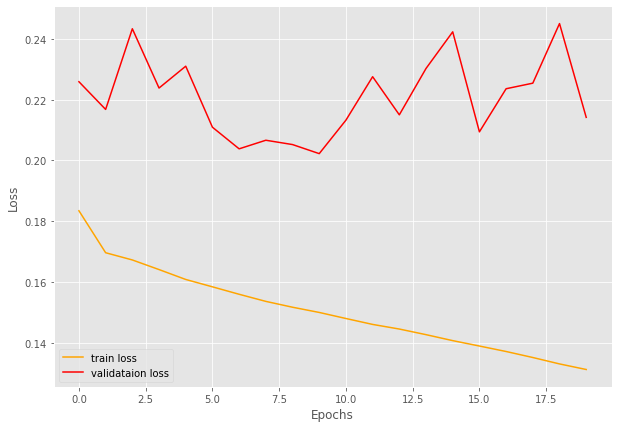

In [10]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model2.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, './resnet_addgcn_MultiLabelSoftMarginLoss_multi_cls.pth')
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./resnet_asl_loss.png')
plt.show()

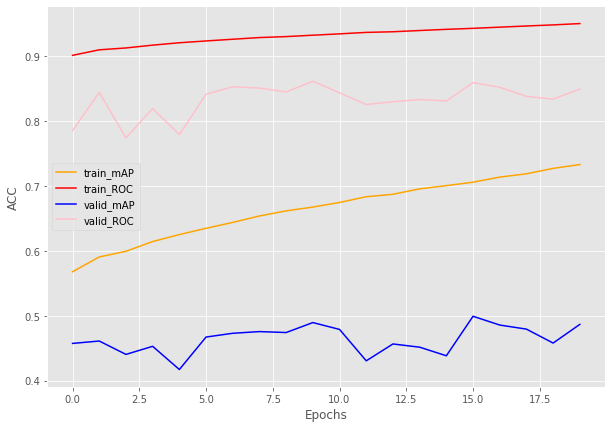

In [11]:
plt.figure(figsize=(10, 7))
plt.plot(train_mAP, color='orange', label='train_mAP')
plt.plot(train_ROC, color='red', label='train_ROC')
plt.plot(valid_mAP, color='blue',label ='valid_mAP')
plt.plot(valid_ROC, color='pink', label='valid_ROC')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.savefig('../resnet_addgcn_ACC.png')
plt.show()

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Classifier().to(device)
# load the model checkpoint
checkpoint = torch.load('./resnet_addgcn_MultiLabelSoftMarginLoss_multi_cls.pth')
# load model weights state_dict
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

RuntimeError: Error(s) in loading state_dict for Classifier:
	Missing key(s) in state_dict: "cnn.0.weight", "cnn.0.bias", "cnn.1.weight", "cnn.1.bias", "cnn.1.running_mean", "cnn.1.running_var", "cnn.4.weight", "cnn.4.bias", "cnn.5.weight", "cnn.5.bias", "cnn.5.running_mean", "cnn.5.running_var", "cnn.8.weight", "cnn.8.bias", "cnn.9.weight", "cnn.9.bias", "cnn.9.running_mean", "cnn.9.running_var", "cnn.12.weight", "cnn.12.bias", "cnn.13.weight", "cnn.13.bias", "cnn.13.running_mean", "cnn.13.running_var", "cnn.16.weight", "cnn.16.bias", "cnn.17.weight", "cnn.17.bias", "cnn.17.running_mean", "cnn.17.running_var", "fc.0.weight", "fc.0.bias", "fc.2.weight", "fc.2.bias", "addfc.weight", "addfc.bias". 
	Unexpected key(s) in state_dict: "mask_mat", "features.0.weight", "features.1.weight", "features.1.bias", "features.1.running_mean", "features.1.running_var", "features.1.num_batches_tracked", "features.4.0.conv1.weight", "features.4.0.bn1.weight", "features.4.0.bn1.bias", "features.4.0.bn1.running_mean", "features.4.0.bn1.running_var", "features.4.0.bn1.num_batches_tracked", "features.4.0.conv2.weight", "features.4.0.bn2.weight", "features.4.0.bn2.bias", "features.4.0.bn2.running_mean", "features.4.0.bn2.running_var", "features.4.0.bn2.num_batches_tracked", "features.4.0.conv3.weight", "features.4.0.bn3.weight", "features.4.0.bn3.bias", "features.4.0.bn3.running_mean", "features.4.0.bn3.running_var", "features.4.0.bn3.num_batches_tracked", "features.4.0.downsample.0.weight", "features.4.0.downsample.1.weight", "features.4.0.downsample.1.bias", "features.4.0.downsample.1.running_mean", "features.4.0.downsample.1.running_var", "features.4.0.downsample.1.num_batches_tracked", "features.4.1.conv1.weight", "features.4.1.bn1.weight", "features.4.1.bn1.bias", "features.4.1.bn1.running_mean", "features.4.1.bn1.running_var", "features.4.1.bn1.num_batches_tracked", "features.4.1.conv2.weight", "features.4.1.bn2.weight", "features.4.1.bn2.bias", "features.4.1.bn2.running_mean", "features.4.1.bn2.running_var", "features.4.1.bn2.num_batches_tracked", "features.4.1.conv3.weight", "features.4.1.bn3.weight", "features.4.1.bn3.bias", "features.4.1.bn3.running_mean", "features.4.1.bn3.running_var", "features.4.1.bn3.num_batches_tracked", "features.4.2.conv1.weight", "features.4.2.bn1.weight", "features.4.2.bn1.bias", "features.4.2.bn1.running_mean", "features.4.2.bn1.running_var", "features.4.2.bn1.num_batches_tracked", "features.4.2.conv2.weight", "features.4.2.bn2.weight", "features.4.2.bn2.bias", "features.4.2.bn2.running_mean", "features.4.2.bn2.running_var", "features.4.2.bn2.num_batches_tracked", "features.4.2.conv3.weight", "features.4.2.bn3.weight", "features.4.2.bn3.bias", "features.4.2.bn3.running_mean", "features.4.2.bn3.running_var", "features.4.2.bn3.num_batches_tracked", "features.5.0.conv1.weight", "features.5.0.bn1.weight", "features.5.0.bn1.bias", "features.5.0.bn1.running_mean", "features.5.0.bn1.running_var", "features.5.0.bn1.num_batches_tracked", "features.5.0.conv2.weight", "features.5.0.bn2.weight", "features.5.0.bn2.bias", "features.5.0.bn2.running_mean", "features.5.0.bn2.running_var", "features.5.0.bn2.num_batches_tracked", "features.5.0.conv3.weight", "features.5.0.bn3.weight", "features.5.0.bn3.bias", "features.5.0.bn3.running_mean", "features.5.0.bn3.running_var", "features.5.0.bn3.num_batches_tracked", "features.5.0.downsample.0.weight", "features.5.0.downsample.1.weight", "features.5.0.downsample.1.bias", "features.5.0.downsample.1.running_mean", "features.5.0.downsample.1.running_var", "features.5.0.downsample.1.num_batches_tracked", "features.5.1.conv1.weight", "features.5.1.bn1.weight", "features.5.1.bn1.bias", "features.5.1.bn1.running_mean", "features.5.1.bn1.running_var", "features.5.1.bn1.num_batches_tracked", "features.5.1.conv2.weight", "features.5.1.bn2.weight", "features.5.1.bn2.bias", "features.5.1.bn2.running_mean", "features.5.1.bn2.running_var", "features.5.1.bn2.num_batches_tracked", "features.5.1.conv3.weight", "features.5.1.bn3.weight", "features.5.1.bn3.bias", "features.5.1.bn3.running_mean", "features.5.1.bn3.running_var", "features.5.1.bn3.num_batches_tracked", "features.5.2.conv1.weight", "features.5.2.bn1.weight", "features.5.2.bn1.bias", "features.5.2.bn1.running_mean", "features.5.2.bn1.running_var", "features.5.2.bn1.num_batches_tracked", "features.5.2.conv2.weight", "features.5.2.bn2.weight", "features.5.2.bn2.bias", "features.5.2.bn2.running_mean", "features.5.2.bn2.running_var", "features.5.2.bn2.num_batches_tracked", "features.5.2.conv3.weight", "features.5.2.bn3.weight", "features.5.2.bn3.bias", "features.5.2.bn3.running_mean", "features.5.2.bn3.running_var", "features.5.2.bn3.num_batches_tracked", "features.5.3.conv1.weight", "features.5.3.bn1.weight", "features.5.3.bn1.bias", "features.5.3.bn1.running_mean", "features.5.3.bn1.running_var", "features.5.3.bn1.num_batches_tracked", "features.5.3.conv2.weight", "features.5.3.bn2.weight", "features.5.3.bn2.bias", "features.5.3.bn2.running_mean", "features.5.3.bn2.running_var", "features.5.3.bn2.num_batches_tracked", "features.5.3.conv3.weight", "features.5.3.bn3.weight", "features.5.3.bn3.bias", "features.5.3.bn3.running_mean", "features.5.3.bn3.running_var", "features.5.3.bn3.num_batches_tracked", "features.6.0.conv1.weight", "features.6.0.bn1.weight", "features.6.0.bn1.bias", "features.6.0.bn1.running_mean", "features.6.0.bn1.running_var", "features.6.0.bn1.num_batches_tracked", "features.6.0.conv2.weight", "features.6.0.bn2.weight", "features.6.0.bn2.bias", "features.6.0.bn2.running_mean", "features.6.0.bn2.running_var", "features.6.0.bn2.num_batches_tracked", "features.6.0.conv3.weight", "features.6.0.bn3.weight", "features.6.0.bn3.bias", "features.6.0.bn3.running_mean", "features.6.0.bn3.running_var", "features.6.0.bn3.num_batches_tracked", "features.6.0.downsample.0.weight", "features.6.0.downsample.1.weight", "features.6.0.downsample.1.bias", "features.6.0.downsample.1.running_mean", "features.6.0.downsample.1.running_var", "features.6.0.downsample.1.num_batches_tracked", "features.6.1.conv1.weight", "features.6.1.bn1.weight", "features.6.1.bn1.bias", "features.6.1.bn1.running_mean", "features.6.1.bn1.running_var", "features.6.1.bn1.num_batches_tracked", "features.6.1.conv2.weight", "features.6.1.bn2.weight", "features.6.1.bn2.bias", "features.6.1.bn2.running_mean", "features.6.1.bn2.running_var", "features.6.1.bn2.num_batches_tracked", "features.6.1.conv3.weight", "features.6.1.bn3.weight", "features.6.1.bn3.bias", "features.6.1.bn3.running_mean", "features.6.1.bn3.running_var", "features.6.1.bn3.num_batches_tracked", "features.6.2.conv1.weight", "features.6.2.bn1.weight", "features.6.2.bn1.bias", "features.6.2.bn1.running_mean", "features.6.2.bn1.running_var", "features.6.2.bn1.num_batches_tracked", "features.6.2.conv2.weight", "features.6.2.bn2.weight", "features.6.2.bn2.bias", "features.6.2.bn2.running_mean", "features.6.2.bn2.running_var", "features.6.2.bn2.num_batches_tracked", "features.6.2.conv3.weight", "features.6.2.bn3.weight", "features.6.2.bn3.bias", "features.6.2.bn3.running_mean", "features.6.2.bn3.running_var", "features.6.2.bn3.num_batches_tracked", "features.6.3.conv1.weight", "features.6.3.bn1.weight", "features.6.3.bn1.bias", "features.6.3.bn1.running_mean", "features.6.3.bn1.running_var", "features.6.3.bn1.num_batches_tracked", "features.6.3.conv2.weight", "features.6.3.bn2.weight", "features.6.3.bn2.bias", "features.6.3.bn2.running_mean", "features.6.3.bn2.running_var", "features.6.3.bn2.num_batches_tracked", "features.6.3.conv3.weight", "features.6.3.bn3.weight", "features.6.3.bn3.bias", "features.6.3.bn3.running_mean", "features.6.3.bn3.running_var", "features.6.3.bn3.num_batches_tracked", "features.6.4.conv1.weight", "features.6.4.bn1.weight", "features.6.4.bn1.bias", "features.6.4.bn1.running_mean", "features.6.4.bn1.running_var", "features.6.4.bn1.num_batches_tracked", "features.6.4.conv2.weight", "features.6.4.bn2.weight", "features.6.4.bn2.bias", "features.6.4.bn2.running_mean", "features.6.4.bn2.running_var", "features.6.4.bn2.num_batches_tracked", "features.6.4.conv3.weight", "features.6.4.bn3.weight", "features.6.4.bn3.bias", "features.6.4.bn3.running_mean", "features.6.4.bn3.running_var", "features.6.4.bn3.num_batches_tracked", "features.6.5.conv1.weight", "features.6.5.bn1.weight", "features.6.5.bn1.bias", "features.6.5.bn1.running_mean", "features.6.5.bn1.running_var", "features.6.5.bn1.num_batches_tracked", "features.6.5.conv2.weight", "features.6.5.bn2.weight", "features.6.5.bn2.bias", "features.6.5.bn2.running_mean", "features.6.5.bn2.running_var", "features.6.5.bn2.num_batches_tracked", "features.6.5.conv3.weight", "features.6.5.bn3.weight", "features.6.5.bn3.bias", "features.6.5.bn3.running_mean", "features.6.5.bn3.running_var", "features.6.5.bn3.num_batches_tracked", "features.7.0.conv1.weight", "features.7.0.bn1.weight", "features.7.0.bn1.bias", "features.7.0.bn1.running_mean", "features.7.0.bn1.running_var", "features.7.0.bn1.num_batches_tracked", "features.7.0.conv2.weight", "features.7.0.bn2.weight", "features.7.0.bn2.bias", "features.7.0.bn2.running_mean", "features.7.0.bn2.running_var", "features.7.0.bn2.num_batches_tracked", "features.7.0.conv3.weight", "features.7.0.bn3.weight", "features.7.0.bn3.bias", "features.7.0.bn3.running_mean", "features.7.0.bn3.running_var", "features.7.0.bn3.num_batches_tracked", "features.7.0.downsample.0.weight", "features.7.0.downsample.1.weight", "features.7.0.downsample.1.bias", "features.7.0.downsample.1.running_mean", "features.7.0.downsample.1.running_var", "features.7.0.downsample.1.num_batches_tracked", "features.7.1.conv1.weight", "features.7.1.bn1.weight", "features.7.1.bn1.bias", "features.7.1.bn1.running_mean", "features.7.1.bn1.running_var", "features.7.1.bn1.num_batches_tracked", "features.7.1.conv2.weight", "features.7.1.bn2.weight", "features.7.1.bn2.bias", "features.7.1.bn2.running_mean", "features.7.1.bn2.running_var", "features.7.1.bn2.num_batches_tracked", "features.7.1.conv3.weight", "features.7.1.bn3.weight", "features.7.1.bn3.bias", "features.7.1.bn3.running_mean", "features.7.1.bn3.running_var", "features.7.1.bn3.num_batches_tracked", "features.7.2.conv1.weight", "features.7.2.bn1.weight", "features.7.2.bn1.bias", "features.7.2.bn1.running_mean", "features.7.2.bn1.running_var", "features.7.2.bn1.num_batches_tracked", "features.7.2.conv2.weight", "features.7.2.bn2.weight", "features.7.2.bn2.bias", "features.7.2.bn2.running_mean", "features.7.2.bn2.running_var", "features.7.2.bn2.num_batches_tracked", "features.7.2.conv3.weight", "features.7.2.bn3.weight", "features.7.2.bn3.bias", "features.7.2.bn3.running_mean", "features.7.2.bn3.running_var", "features.7.2.bn3.num_batches_tracked", "conv_transform.weight", "conv_transform.bias", "gcn.static_adj.0.weight", "gcn.static_weight.0.weight", "gcn.static_weight.0.bias", "gcn.conv_global.weight", "gcn.conv_global.bias", "gcn.bn_global.weight", "gcn.bn_global.bias", "gcn.bn_global.running_mean", "gcn.bn_global.running_var", "gcn.bn_global.num_batches_tracked", "gcn.conv_create_co_mat.weight", "gcn.conv_create_co_mat.bias", "gcn.dynamic_weight.weight", "gcn.dynamic_weight.bias", "last_linear.weight", "last_linear.bias", "fc.weight". 

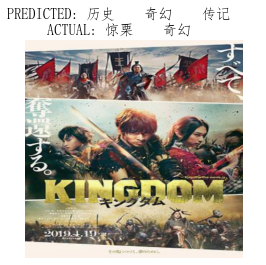

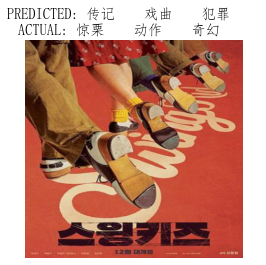

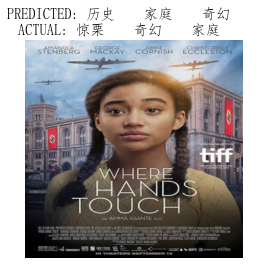

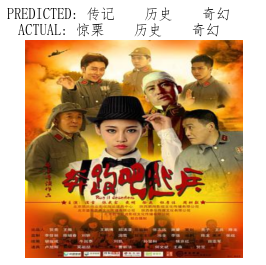

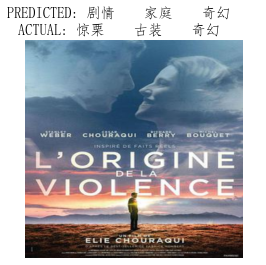

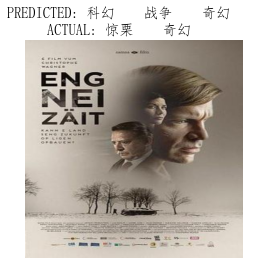

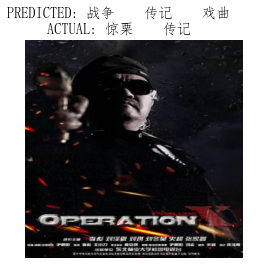

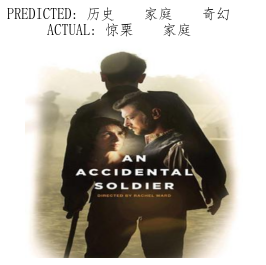

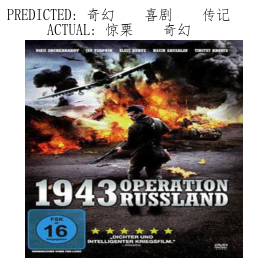

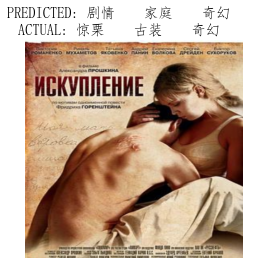

In [16]:
import pylab as mpl
mpl.rcParams['font.sans-serif'] = ['FangSong']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False
train_csv = pd.read_csv('D:\ML_data_sql\info_label_clean.csv')
genres = train_csv.columns.values[1:]
# prepare the test dataset and dataloader
test_data = ImageDataset(
    train_csv, train=False, test=True
)
test_loader = DataLoader(
    test_data, 
    batch_size=1,
    shuffle=False
)
for counter, data in enumerate(test_loader):
    image, target = data['image'].to(device), data['label']
    # get all the index positions where value == 1
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]
    # get the predictions by passing the image through the model
    # print(image.shape,target.shape)
    output1,output2 = model2(image)
    # outputs = torch.sigmoid(outputs)
    outputs = (output1+output2)/2
    outputs = outputs.detach().cpu()
    sorted_indices = np.argsort(outputs[0])
    best = sorted_indices[-3:]
    string_predicted = ''
    string_actual = ''
    for i in range(len(best)):
        string_predicted += f"{genres[best[i]]}    "
    for i in range(len(target_indices)):
        string_actual += f"{genres[target_indices[i]]}    "
    image = image.squeeze(0)
    image = image.detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
    plt.savefig(f"./inference_resnet_addgcn{counter}.jpg")
    plt.show()